In [46]:
from skimage import io,morphology as m,filters,feature
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
import pandas as pd
import cv2

ModuleNotFoundError: No module named 'cv2'

In [9]:
def t1(A):
    fig,ax=plt.subplots(1,3,figsize=(10,3))
    ax[0].imshow(A,cmap='gray')
    ax[0].set_axis_off()
    
    e=m.erosion(A,m.diamond(4))
    ax[1].imshow(e,cmap='gray')
    ax[1].set_axis_off()
    
    clear=m.remove_small_holes(e,64)
    clear=(255*clear).astype('uint8')
    ax[2].imshow(clear,cmap='gray')
    ax[2].set_axis_off()
    
    return clear
def h_lines(mask):
    #Detects horizontal lines of the grid (Hough algorithm)
    tested_angles = np.linspace(np.pi/4, 3*np.pi/4 , 360, endpoint=False)
    h, theta, d = hough_line(mask, theta=tested_angles)
    a,b,c=hough_line_peaks(h, theta, d)
    return 90-np.median(np.rad2deg(b)),np.round(np.sort(np.sin(b)*c)).astype(int)

def v_lines(mask):
    #Detects vertical lines of the grid (Hough algorithm)
    tested_angles = np.linspace(-np.pi/4, np.pi/4 , 360, endpoint=False)
    h, theta, d = hough_line(mask, theta=tested_angles)
    a,b,c=hough_line_peaks(h, theta, d)
    
    return int(np.median(np.diff(np.sort(np.cos(b)*c))))


def yt_1(y,h):
    #gets the top grid Y scale, Heart Rate 1 (HR1)
    return (160/h)*(h-y)+50

def yt_2(y,h):
    #gets the bottom grid Y scale, tocography (TOCO)
    return (100/h)*(h-y)

def xt(x,step:int):
    #trasformation of scale X time. According to a cell equals 30s
    seg=30/step
    
    return x*seg

C:\Users\david\AppData\Local\Temp\ipykernel_8552\1856890880.py:10: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  clear=m.remove_small_holes(e,64)


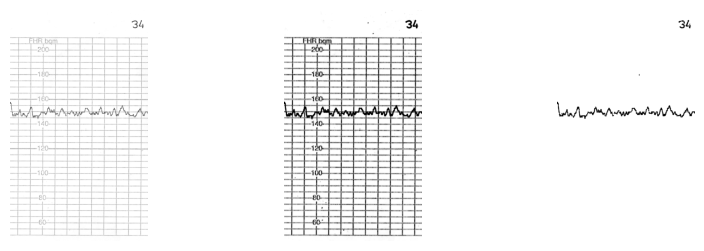

In [5]:
A=io.imread('./assets/D1.jpg')
A=A[:,:,0]
clear=t1(A)

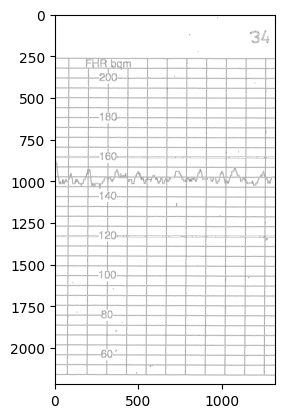

In [39]:
mask=canny(A)*1
plt.imshow(1-mask,cmap='gray')

In [43]:
angulo,p=h_lines(mask)
if angulo!=0:
        (h, w) = a.shape[:2]
        centro = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(centro, -angulo, 1.0)
        a = cv2.warpAffine(a, M, (w, h),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        hsv=cv2.warpAffine(hsv, M, (w, h),
                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


array([0, 0, 0, ..., 1, 1, 0])

In [40]:
h_lines(mask)

(-0.2500000000000142,
 array([ 268,  324,  387,  442,  498,  561,  617,  680,  735,  795,  859,
         913,  972, 1031, 1091, 1150, 1212, 1268, 1325, 1387, 1446, 1509,
        1568, 1624, 1687, 1746, 1802, 1862, 1924, 1980, 2039, 2102, 2161]))

In [22]:
mask=canny(clear.astype(float))*1
step=v_lines(mask)
y,x=np.where((mask))
y=yt_1(y,clear.shape[0])
x=xt(x,step)
d=pd.DataFrame(sorted(zip(x,y)))
d=d[d.loc[:,1]<=200]
d=d[d.loc[:,1]>=60]
d=d.groupby(0).median()
x=d.index
y=d[1].values
s=d.rolling(round(step),center=True).std().backfill().ffill()
m=d.rolling(round(step),center=True).median().backfill().ffill()

dele=[]
for i in range(len(y)):
    if y[i]>(m+2.5*s).iloc[i,0] or y[i]< (m-2.5*s).iloc[i,0]:
        dele.append(i)

for i in dele:
        y[i]=m.iloc[i,0]
        
        
a=pd.Series(y,index=pd.DatetimeIndex(x*1e9))
a.resample('0.25S').median().ffill(limit=2)

C:\Users\david\AppData\Local\Temp\ipykernel_8552\554235027.py:12: FutureWarning: DataFrame.backfill/Series.backfill is deprecated. Use DataFrame.bfill/Series.bfill instead
  s=d.rolling(round(step),center=True).std().backfill().ffill()
C:\Users\david\AppData\Local\Temp\ipykernel_8552\554235027.py:13: FutureWarning: DataFrame.backfill/Series.backfill is deprecated. Use DataFrame.bfill/Series.bfill instead
  m=d.rolling(round(step),center=True).median().backfill().ffill()


0
1970-01-01 00:00:07.500    145.004509
1970-01-01 00:00:07.750    145.004509
1970-01-01 00:00:08.000    145.004509
1970-01-01 00:00:08.250           NaN
1970-01-01 00:00:08.500           NaN
                              ...    
1970-01-01 02:45:06.500           NaN
1970-01-01 02:45:06.750           NaN
1970-01-01 02:45:07.000           NaN
1970-01-01 02:45:07.250           NaN
1970-01-01 02:45:07.500    139.341749
Freq: 250L, Length: 39601, dtype: float64

<Axes: xlabel='0'>

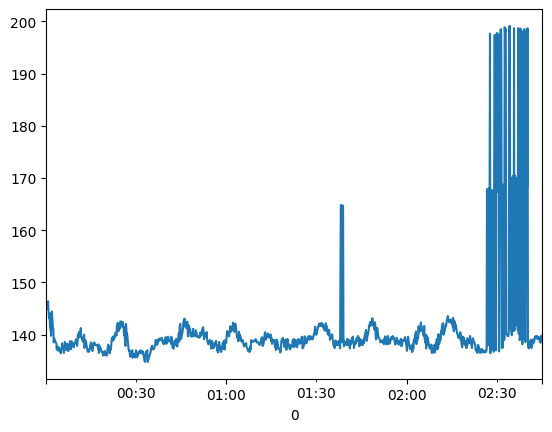

In [23]:
a.plot()
plt.ylim(50,210)